### Feature Sampling
So far, we have learned how to generate a continuous, homogeneous, and structured dataset from unstructured financial data. While it is possible to attempt to apply machine learning algorithms to such a dataset, this is generally not a good idea for several reasons.

1. Some machine learning algorithms do not perform efficiently as the sample size increases.
2. Machine learning algorithms achieve the highest accuracy when learning from related examples.

Suppose we want to predict whether the 5% absolute return will be positive or negative. At any given time, the likelihood of such a prediction being accurate is low. However, if we use a classification methodology to predict the sign of the next 5% absolute return after a catalytic event occurs, we are more likely to find informative features that allow for a more refined prediction. Let's explore how to sample the extracted bars to create a feature matrix with related learning examples.
Suppose we want to predict whether the 5% absolute return will be positive or negative. At any given time, the likelihood of such a prediction being accurate is low. However, if we use a classification methodology to predict the sign of the next 5% absolute return after a catalytic event occurs, we are more likely to find informative features that allow for a more refined prediction. Let's explore how to sample the extracted bars to create a feature matrix with related learning examples.


In [1]:
from quant_free.finml.barsampling.core import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_parquet('./research/Data/IVEfuture.parquet')
data['date'] = pd.to_datetime(data['date'])
bar = StandardBarFeatures(file_path_or_df = data)

#### 1. Sampling for Reduction

As mentioned earlier, one of the reasons for sampling features from structured data is to reduce the amount of data used for machine learning fitting. This operation is called down sampling. Often, samples are sequentially extracted at fixed step sizes (linspace sampling) or randomly sampled using a uniform distribution (uniform sampling).

The advantage of linspace sampling is its simplicity, while its disadvantage is that the step size is arbitrary and can be uneven depending on the seed bar. Uniform sampling solves this problem by sampling uniformly from the entire set of bars. Both methods have received much criticism because there is no guarantee that the samples contain the most relevant observations in terms of information content or predictive power.


#### 2. Event Based Sampling

Portfolio managers place bets after structural breaks, market signals, or microstructural features occur. These events may be linked to volatility expansion, excessive deviation of spreads from equilibrium levels, or macroeconomic statistics announcements. Events can be characterized as significant, and machine learning can be used to learn whether sophisticated predictive functions exist under these circumstances. The answer may likely be 'no', but in such cases, we can redefine the event construction or try again with different features. As an example, let's examine one useful method of event-based sampling.

##### 2.1 CUSUM Filter

The `Cumulative sum filter` is a quality control technique designed to detect how much a measurement deviates from the target mean. Consider $\mathrm{IID}$ observations $\{y_t\}_{t=1,\dots,T}$ generated from a locally stationary process. The Cumulative Sum is defined as:

$$S_t = \max{\{
0, S_{t-1} + y_t - E_{t-1}[y_t]
\}}$$

Here, the boundary condition is $S_0 = 0$. This procedure will recommend action at the first $t$ where $S_t \geq h$ for a specific threshold $h$ (filter size). Note that whenever $y_t \leq E_{t-1}[y_t] - S_{t-1}$, $S_t = 0$. The zero lower bound means downward deviations are ignored to prevent $S_t$ from becoming negative. This is because the filter is set to identify sequences diverging upward from all reset levels of 0. Specifically, the threshold is activated in the following case:

$$S_t \geq h \Leftrightarrow \exists \tau \in [1,t] \Big| \sum_{i=\tau}^t \left(
y_t - E_{i-1}[y_t]
\right) \geq h$$

This concept of upward accumulation can be extended to include downward accumulation, forming a symmetric $\mathrm{CUSUM}$ filter:

$$S_t^+ = \max{\{
0, S_{t-1}^+ + y_t - E_{t-1}[y_t]
\}}, S_0^+ = 0$$

$$S_t^- = \max{\{
0, S_{t-1}^- + y_t - E_{t-1}[y_t]
\}}, S_0^- = -$$

$$S_t = \max \{S_t^+, S_t^-\}$$

Lam and Yam (1997) proposed an investment strategy that generates buy/sell signals when the absolute return $h$ is found at previous highs or lows. They proved that this strategy is equivalent to the so-called filter trading strategy studied by Fama and Blume (1966). Here, the use of the $\mathrm{CUSUM}$ filter is slightly different. We only sample bar $t$ when $S_t \geq h$ and $S_t$ resets. The code below shows a symmetric $\mathrm{CUSUM}$ filter with $E_{t-1}[y_t] = y_{t-1}$.
End of Selection

In [3]:
dollar = bar.dollar_bar()

Reading data in batches:
Batch number: 0
Batch number: 1
Batch number: 2
Batch number: 3
Batch number: 4
Batch number: 5
Batch number: 6
Batch number: 7
Batch number: 8
Batch number: 9
Batch number: 10
Batch number: 11
Returning bars 



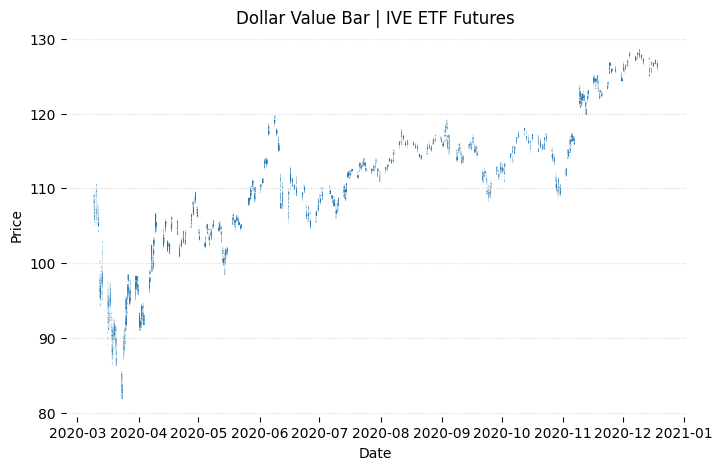

In [4]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    dollar.loc[147500 : 167500]['date_time'],
    dollar.loc[147500 : 167500]['close'],
    s = 1, 
    marker = '.', 
    edgecolor = 'none', 
    alpha = 0.5
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Dollar Value Bar | IVE ETF Futures')
plt.show()

In [5]:
from quant_free.finml.filter.filter import cusum_filter

cusum_events = cusum_filter(
    dollar.close, 
    threshold = 1.5, 
    time_stamps = False
)

In [6]:
cusum_filtered = dollar.loc[cusum_events]

In [7]:
cusum_filtered

,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
102,2009-10-01 11:34:51,8775,50.39,50.390,50.24,50.26,20349,10595,104,1.023180e+06
188,2009-10-06 09:29:52,16154,50.47,50.920,50.43,50.92,20466,14710,88,1.033263e+06
302,2009-10-14 09:30:00,25958,51.92,52.680,51.91,52.66,19194,13048,74,1.001172e+06
516,2009-10-26 11:32:01,45946,51.58,51.620,51.47,51.48,19450,8514,90,1.002772e+06
583,2009-10-28 12:42:26,51770,50.09,50.090,49.97,49.97,20053,7518,82,1.003064e+06
...,...,...,...,...,...,...,...,...,...,...
236313,2024-03-20 14:04:56,11278232,183.51,183.680,183.50,183.68,5477,3159,36,1.005445e+06
236354,2024-03-21 09:42:40,11279714,184.60,184.750,184.60,184.75,5510,2726,51,1.017568e+06
236454,2024-03-22 16:00:00,11282760,183.92,183.920,183.56,183.56,7143,1151,34,1.311938e+06
236582,2024-03-27 09:35:12,11286519,184.57,184.805,184.57,184.79,5437,3129,37,1.004368e+06


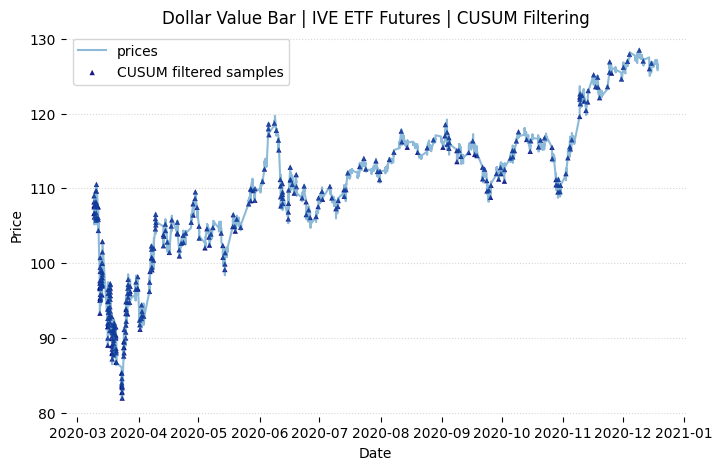

In [8]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    dollar.loc[147500 : 167500]['date_time'],
    dollar.loc[147500 : 167500]['close'],
    alpha = 0.5,
    label = 'prices'
)
ax.scatter(
    cusum_filtered.loc[147500 : 167500]['date_time'],
    cusum_filtered.loc[147500 : 167500]['close'],
    alpha = 0.9,
    marker = '^',
    label = 'CUSUM filtered samples',
    edgecolor = 'none',
    color = 'navy',
    s = 15
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title('Dollar Value Bar | IVE ETF Futures | CUSUM Filtering')
plt.show()

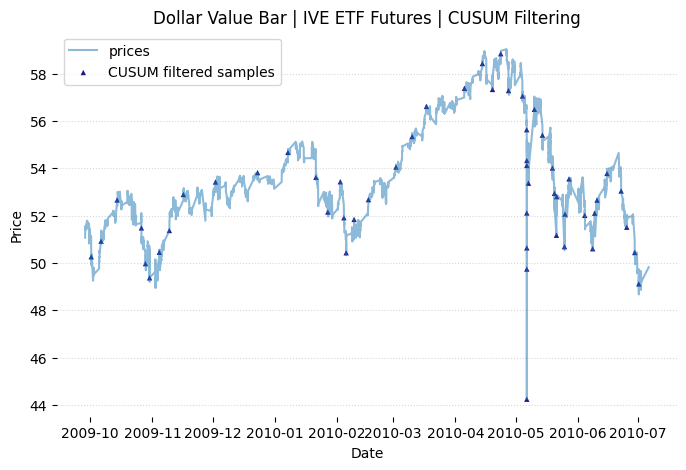

In [9]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    dollar.loc[: 5000]['date_time'],
    dollar.loc[: 5000]['close'],
    alpha = 0.5,
    label = 'prices'
)
ax.scatter(
    cusum_filtered.loc[: 5000]['date_time'],
    cusum_filtered.loc[: 5000]['close'],
    alpha = 0.9,
    marker = '^',
    label = 'CUSUM filtered samples',
    edgecolor = 'none',
    color = 'navy',
    s = 15
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title('Dollar Value Bar | IVE ETF Futures | CUSUM Filtering')
plt.show()

변수 $S_t$는 Structural Break Statistics, Entropy 또는 Market microstructural featurs 등 모든 특성에 기반을 둘 수 있다. 예를 들어서, Supremum ADF 통계량이 이전의 레벨로부터 충분히 벗어날 때마다 이벤트가 발생할 수 있다

Event driven bar의 부분 집합을 얻으면 이러한 이벤트의 발생이 실행 가능성 정보를 구성하는지를 Machine Learning 알고리즘이 결정하도록 한다